# **Applied Deep Learning - Final Project**
# tmatrixhy
# Professor Josh Gordon

Project Description:

Detection and classification of breast cancer metastases in lymph nodes using Deep Learning on the [CAMELYON 16](https://camelyon17.grand-challenge.org/Background/) dataset.

REFERENCES

1. http://cs231n.github.io/transfer-learning/ - Transfer Learning
2. https://gist.github.com/tomahim/9ef72befd43f5c106e592425453cb6ae - Image Flip / Rotate for data augmentation.
3. https://github.com/googlecolab/colabtools/issues/253 - Crash Colab Trick for more RAM for runtime.

In [0]:
# OVERFLOW GOOGLE COLAB RUNTIME TO GAIN ACCES TO MORE RAM :)
d=[]
while(1):
  d.append('1')

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (62.3 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
'''
Dependencies
'''
try:
  %tensorflow_version 2.x
except Exception:
  pass
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import random
import os
import glob
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from scipy import ndarray
import skimage as sk

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta

TensorFlow 2.x selected.


In [0]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content


In [0]:
# generate list of files on Google Drive
tumor_files = glob.glob("/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_???.tif")
mask_files = glob.glob("/content/drive/My Drive/CAMELYON16/slides2/*mask.tif")

# remove only file without mask
tumor_files.remove('/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_038.tif')

# verify each file has a mask file
assert len(tumor_files)== len(mask_files)

# Add double quotes to path
tumor_files = ["\"" + x + "\"" for x in tumor_files]
mask_files = ["\"" + x + "\"" for x in mask_files]

print(mask_files)
print(tumor_files)
print(len(mask_files))
print(len(tumor_files))

['"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_012_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_001_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_002_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_005_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_016_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_019_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_023_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_031_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_035_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_057_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_059_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_075_mask.tif"', '"/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_064_mask.tif"', '"/content/drive/My Driv

In [0]:
# Copy data from Google Drive to local runtime for faster processing.
# Comment out this block to skip this step, code can work from Cloud

!mkdir /content/slides

# copy tumor file + mask file to local runtime
counter = 0
for tumor_f, mask_f in zip(tumor_files, mask_files):
  counter += 1
  !cp $tumor_f /content/slides/
  print("Copied the following file to local runtime: %s" %(tumor_f))
  !cp $mask_f /content/slides/
  print("Copied the following file to local runtime: %s" %(mask_f))
  if (counter == 10):
    break

# generate list of files
tumor_files = glob.glob("/content/slides/Copy of tumor_???.tif")
mask_files = glob.glob("/content/slides/*mask.tif")

# verify each file has a mask file
# assert len(tumor_files)== len(mask_files)

Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_002.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_012_mask.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_001.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_001_mask.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_005.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_002_mask.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_019.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy of tumor_005_mask.tif"
Copied the following file to local runtime: "/content/drive/My Drive/CAMELYON16/slides2/Copy

In [0]:
# VERIFICATION OF INPUT DATA

tumor_files = glob.glob("/content/slides/Copy of tumor_???.tif")
mask_files = glob.glob("/content/slides/*mask.tif")
tumor_files = sorted(tumor_files)
mask_files = sorted(mask_files)

for slide_path, tumor_mask_path in zip(tumor_files, mask_files):
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))

  for i in range(len(slide.level_dimensions)-1):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                              slide.level_dimensions[i], 
                                                              slide.level_downsamples[i]))
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/slides/Copy of tumor_001.tif with width: 97792, height: 221184
Read tumor mask from /content/slides/Copy of tumor_001_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256
Read WSI from /content/slides/Copy of tumor_002.tif with width: 97792, height: 219648
Read tumor mask from /content/slides/Copy of tumor_002_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 219648) downsample factor 1
Level 1, dimensions: (48896, 109824) downsample factor 2
Level 2, dimensions: (24448, 

# HELPER FUNCTIONS

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def sum_array(input_arr):
  total = 0
  for x in input_arr:
    total+=np.sum(x)
  
  return total

'''
  process_cancerous_area
    @args
      slide       = current slide being processed
      tumor_mask  = current tumor mask being processed
      x_in        = image start Xa value
      y_in        = image start Ya value
    
    This function is called when cancerous cells are detected in the current
    default_zoom level. This function ammends the dataset with zoomed images
    from the input patch.
'''
def process_cancerous_area(slide, tumor_mask, x_in, y_in):
  start_point_x = x_in
  start_point_y = y_in
  end_x = start_point_x
  end_y = start_point_y
  i = 0
  for x in range (default_zoom-1, max_zoom-1, -1):
    # ZOOM IN
    i+=1
    start_point_x*=2
    start_point_y*=2
    end_x = start_point_x + (i * extra_stride)
    end_y = start_point_y + (i * extra_stride)
    for xa in range (start_point_x, end_x):
      for ya in range (start_point_y, end_y):
        # EXTRACT LOCAL SAMPLE
        create_dataset(slide, tumor_mask, xa, ya, x)

'''
  create_dataset
    @args
      slide       = current slide being processed
      tumor_mask  = current tumor mask being processed
      x_in        = image start Xa value
      y_in        = image start Ya value
      x           = level
    This function is called when the dataset needs to be amended.
'''
def create_dataset(slide, tumor_mask, xa, ya, x):
  local_region = read_slide(slide,
                    x= xa * SAMPLE_SIZE * int(slide.level_downsamples[x]),
                    y= ya * SAMPLE_SIZE * int(slide.level_downsamples[x]),
                    level= x,
                    width= SAMPLE_SIZE,
                    height= SAMPLE_SIZE)
  
  #CHECK FOR TISSUE
  tissue_pixels = find_tissue_pixels(local_region)
  percent_tissue = len(list(tissue_pixels)) / float(local_region.shape[0] * local_region.shape[1]) * 100
  
  # CHECK IF TISSUE LEVEL IS ABOVE THRESHOLD
  if percent_tissue >= threshold_percentage :
    sampled_tissue[x].append(apply_mask(local_region, tissue_pixels))
    mask = read_slide(tumor_mask, 
                                x= xa * SAMPLE_SIZE * int(slide.level_downsamples[x]), 
                                y= ya * SAMPLE_SIZE * int(slide.level_downsamples[x]), 
                                level= x, 
                                width= SAMPLE_SIZE, 
                                height= SAMPLE_SIZE)[:,:,0]
    sampled_mask[x].append(mask)
    # check if cancerous tissue is found in the mask; process data
    if np.any(mask):
      # CANCER DETECTED
      cancer_exists[x].append(1)
      if x == default_zoom:
        # ZOOM IN if starting point is default_zoom
        process_cancerous_area(slide, tumor_mask, xa, ya)
    else:
      # NO CANCER FOUND
      cancer_exists[x].append(0)

# GLOBAL VARIABLES AND DEFINITIONS

In [0]:
'''
Data Engineering
'''


# define image size to sample - Chose 224 - default input for ResNet50
SAMPLE_SIZE                 = 224

# Threshold for % tissue detected in a local sample to retain data
threshold_percentage        = 5.0

# normal tissue dataset
sampled_tissue              = [[],[],[],[],[]]
# masks
sampled_mask                = [[],[],[],[],[]]
# cancer dataset
cancer_exists               = [[],[],[],[],[]]

# zoom levels
default_zoom                = 4
max_zoom                    = 0
zoom_depth                  = default_zoom - (max_zoom-1)

# extra strides for zoom
extra_stride                = 3

# maximum amount of slides to load, crashes on 13 slides in ram 
max_slides                  = 9

# GENERATE RAW DATASET




In [0]:
slides_to_load = 0

for slide_path, tumor_mask_path in zip(tumor_files, mask_files):
  print("Working on slide: %s" % (slide_path))
  slides_to_load += 1
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  for xa in range (0, int(slide.level_dimensions[default_zoom][0]/SAMPLE_SIZE)-1):
    for ya in range (0, int(slide.level_dimensions[default_zoom][1]/SAMPLE_SIZE)-1):
      create_dataset(slide, tumor_mask, xa, ya, default_zoom)
  
  if (slides_to_load >= max_slides):
    break

print("Total Cancer Count        : " + str(sum_array(cancer_exists)))

Working on slide: /content/slides/Copy of tumor_001.tif
Working on slide: /content/slides/Copy of tumor_002.tif
Working on slide: /content/slides/Copy of tumor_005.tif
Working on slide: /content/slides/Copy of tumor_012.tif
Working on slide: /content/slides/Copy of tumor_016.tif
Working on slide: /content/slides/Copy of tumor_019.tif
Working on slide: /content/slides/Copy of tumor_023.tif
Working on slide: /content/slides/Copy of tumor_031.tif
Working on slide: /content/slides/Copy of tumor_035.tif
Total Cancer Count        : 8900


In [0]:
print(len(sampled_tissue[0]))
print(len(sampled_mask[1]))
print(len(cancer_exists[2]))

11260
6301
2713


Sanity Check - Check Ratios of cancerous and non-cancerous data.

In [0]:
augment_ratio = []

print("                              --- Ratio of Data ---")
for x in range(len(sampled_tissue)):
  augment_ratio.append(int(len(sampled_tissue[x])/np.sum(cancer_exists[x])))
  print("Zoom Level %d - (Total : Cancerous) Samples : (%5.d / %5.d): -- Percentage: %.4f " % 
        (x, 
         len(sampled_tissue[x]), 
         np.sum(cancer_exists[x]), 
         len(sampled_tissue[x])/np.sum(cancer_exists[x])))


                              --- Ratio of Data ---
Zoom Level 0 - (Total : Cancerous) Samples : (11260 /  4160): -- Percentage: 2.7067 
Zoom Level 1 - (Total : Cancerous) Samples : ( 6301 /  2790): -- Percentage: 2.2584 
Zoom Level 2 - (Total : Cancerous) Samples : ( 2713 /  1404): -- Percentage: 1.9323 
Zoom Level 3 - (Total : Cancerous) Samples : (  713 /   454): -- Percentage: 1.5705 
Zoom Level 4 - (Total : Cancerous) Samples : ( 1920 /    92): -- Percentage: 20.8696 


Sanity Check - Check Images and Mask Extracted

##-- Sample Image at zoom level 4. --##


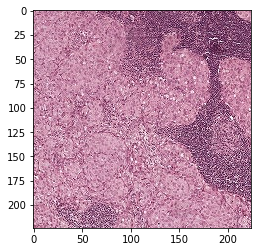

In [0]:
test_zoom_level = 4
test_img_number = 1649
plt.imshow(sampled_tissue[test_zoom_level][test_img_number])

print("##-- Sample Image at zoom level %d. --##" %(test_zoom_level))

##-- Cancer FOUND on this slide. --##


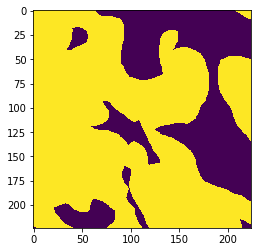

In [0]:
plt.imshow(sampled_mask[test_zoom_level][test_img_number])

if (cancer_exists[test_zoom_level][test_img_number] == 1):
  print("##-- Cancer FOUND on this slide. --##")
else:
  print("##-- Cancer NOT FOUND on this slide. --##")

# BEGIN MODEL CREATION




**GLOBAL VARIABLES FOR MODEL**

In [0]:
'''
Model Engineering
'''
# cancerous data -- Augmented
cancerous               = [[],[],[],[],[]]
cancerous_mask          = [[],[],[],[],[]]
# non cancerous data -- Unaugmented
non_cancerous           = [[],[],[],[],[]]
non_cancerous_mask      = [[],[],[],[],[]]

# train val test split - cancerous
cancerous_tr, cancerous_val, cancerous_Yi_tr, cancerous_Yi_val =  [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]
cancerous_val, cancerous_test, cancerous_Yi_val, cancerous_Yi_test = [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]
# train val test split - non cancerous
non_cancerous_tr, non_cancerous_val, non_cancerous_Yi_tr, non_cancerous_Yi_val =  [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]
non_cancerous_val, non_cancerous_test, non_cancerous_Yi_val, non_cancerous_Yi_test = [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]

# merged augmented data
full_dataset_train      = [[],[],[],[],[]]
full_dataset_Yi_train   = [[],[],[],[],[]]

full_dataset_val        = [[],[],[],[],[]]
full_dataset_Yi_val     = [[],[],[],[],[]]

full_dataset_test       = [[],[],[],[],[]]
full_dataset_Yi_test    = [[],[],[],[],[]]


#learning rate - reduced due to using pre-trained model
learning_rate               = 0.001

**HELPER FUNCTIONS**

In [0]:
def rand_rotate(img: ndarray):
  rand_deg = random.uniform(-180,180)
  return sk.transform.rotate(img,rand_deg)

def flip_horiz(img:ndarray):
  return img[:, ::-1]

def plot(history):
  # FROM ASSIGNMENT 1
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

# Order data to create a train val test split.

In [0]:
for level in range(zoom_depth):
  for tissue, mask, cancer in zip(sampled_tissue[level], 
                                  sampled_mask[level], 
                                  cancer_exists[level]):
    if cancer == 0:
      non_cancerous[level].append(tissue)
      non_cancerous_mask[level].append(mask)
    elif cancer == 1:
      cancerous[level].append(tissue)
      cancerous_mask[level].append(mask)
  assert len(cancerous[level]) == len(cancerous_mask[level])
  assert len(non_cancerous[level]) == len(non_cancerous_mask[level])

  print("Zoom Level %d - Length of Cancerous dataset     : %6.d"%(level,len(cancerous[level])))
  print("Zoom Level %d - Length of Non-Cancerous dataset : %6.d"%(level,len(non_cancerous[level])))

print("Complete NOW")

Zoom Level 0 - Length of Cancerous dataset     :   4160
Zoom Level 0 - Length of Non-Cancerous dataset :   7100
Zoom Level 1 - Length of Cancerous dataset     :   2790
Zoom Level 1 - Length of Non-Cancerous dataset :   3511
Zoom Level 2 - Length of Cancerous dataset     :   1404
Zoom Level 2 - Length of Non-Cancerous dataset :   1309
Zoom Level 3 - Length of Cancerous dataset     :    454
Zoom Level 3 - Length of Non-Cancerous dataset :    259
Zoom Level 4 - Length of Cancerous dataset     :     92
Zoom Level 4 - Length of Non-Cancerous dataset :   1828
Complete NOW


In [0]:
# Clear ram if code above outputs valid results
del(sampled_tissue)
del(sampled_mask)
del(cancer_exists)

# TRAIN (80%) VAL (10%) TEST (10%) SPLIT

In [0]:
for x in range(zoom_depth):
  cancerous_tr[x], cancerous_val[x], cancerous_Yi_tr[x], cancerous_Yi_val[x] = train_test_split(
      cancerous[x],
      np.ones(len(cancerous[x])),
      test_size =.2,
      stratify=np.ones(len(cancerous[x])))
  cancerous_val[x], cancerous_test[x], cancerous_Yi_val[x], cancerous_Yi_test[x] = train_test_split(
      cancerous_val[x],
      cancerous_Yi_val[x],
      test_size =.5,
      stratify=cancerous_Yi_val[x])
  non_cancerous_tr[x], non_cancerous_val[x], non_cancerous_Yi_tr[x], non_cancerous_Yi_val[x] = train_test_split(
      non_cancerous[x],
      np.zeros(len(non_cancerous[x])),
      test_size=.2,
      stratify=np.zeros(len(non_cancerous[x])))
  non_cancerous_val[x], non_cancerous_test[x], non_cancerous_Yi_val[x], non_cancerous_Yi_test[x] = train_test_split(
      non_cancerous_val[x],
      non_cancerous_Yi_val[x],
      test_size =.5,
      stratify=non_cancerous_Yi_val[x])



In [0]:
# Clear RAM if code above outputs valid results
del(cancerous)
del(non_cancerous)
#del(non_cancerous_mask)
#del(cancerous_mask)

Sanity Check - Check need for Data Augmentation after train val test split.

In [0]:
augment_ratio = []

print("                              --- Ratio of Data ---")
for x in range(zoom_depth):
  augment_ratio.append(int(len(non_cancerous_tr[x])/len(cancerous_tr[x])))
  print("Zoom Level %d - (Non-Cancerous : Cancerous) Samples : (%5.d / %5.d): -- Percentage: %.4f " % 
        (x, 
         len(non_cancerous_tr[x]), 
         len(cancerous_tr[x]), 
         len(non_cancerous_tr[x])/len(cancerous_tr[x])))
augment_ratio

                              --- Ratio of Data ---
Zoom Level 0 - (Non-Cancerous : Cancerous) Samples : ( 5680 /  3328): -- Percentage: 1.7067 
Zoom Level 1 - (Non-Cancerous : Cancerous) Samples : ( 2808 /  2232): -- Percentage: 1.2581 
Zoom Level 2 - (Non-Cancerous : Cancerous) Samples : ( 1047 /  1123): -- Percentage: 0.9323 
Zoom Level 3 - (Non-Cancerous : Cancerous) Samples : (  207 /   363): -- Percentage: 0.5702 
Zoom Level 4 - (Non-Cancerous : Cancerous) Samples : ( 1462 /    73): -- Percentage: 20.0274 


[1, 1, 0, 0, 20]

#Augmenting Zoom Level: 4

Data is balanced on all zoom levels except default_zoom.

In [0]:
augmented_cancerous_tr = []

for data in cancerous_tr[4]:
  augmented_cancerous_tr.append(data)
  for x in range(0,2):
    augmented_cancerous_tr.append(rand_rotate(data))
  data = flip_horiz(data)
  for x in range(0,2):
    augmented_cancerous_tr.append(rand_rotate(data))

len(augmented_cancerous_tr)

365

# Merge All Datasets

In [0]:
for x in range(zoom_depth):
  if x == 4:
    full_dataset_train[x]      = np.concatenate((augmented_cancerous_tr,non_cancerous_tr[x]), axis=0)
    full_dataset_Yi_train[x]   = np.concatenate([np.ones(len(augmented_cancerous_tr)),non_cancerous_Yi_tr[x]])
  else:
    full_dataset_train[x]      = np.concatenate((cancerous_tr[x],non_cancerous_tr[x]), axis=0)
    full_dataset_Yi_train[x]   = np.concatenate([cancerous_Yi_tr[x],non_cancerous_Yi_tr[x]])

  full_dataset_val[x]        = np.concatenate((cancerous_val[x],non_cancerous_val[x]), axis=0)
  full_dataset_Yi_val[x]     = np.concatenate([cancerous_Yi_val[x],non_cancerous_Yi_val[x]])

  full_dataset_test[x]       = np.concatenate((cancerous_test[x],non_cancerous_test[x]), axis=0)
  full_dataset_Yi_test[x]    = np.concatenate([cancerous_Yi_test[x],non_cancerous_Yi_test[x]])

In [0]:
# clean up - Hacky Memory Cleanup

# train val test split - cancerous
cancerous_tr, cancerous_val, cancerous_Yi_tr, cancerous_Yi_val =  [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]
cancerous_val, cancerous_test, cancerous_Yi_val, cancerous_Yi_test = [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]
# train val test split - non cancerous
non_cancerous_tr, non_cancerous_val, non_cancerous_Yi_tr, non_cancerous_Yi_val =  [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]
non_cancerous_val, non_cancerous_test, non_cancerous_Yi_val, non_cancerous_Yi_test = [[],[],[],[],[]], [[],[],[],[],[]] , [[],[],[],[],[]] , [[],[],[],[],[]]

'\ndel(cancerous_tr)\ndel(cancerous_val)\ndel(cancerous_Yi_tr)\ndel(cancerous_Yi_val)\ndel(cancerous_val)\ndel(cancerous_test)\ndel(cancerous_Yi_val)\ndel(cancerous_Yi_test)\ndel(non_cancerous_tr)\ndel(non_cancerous_val)\ndel(non_cancerous_Yi_tr)\ndel(non_cancerous_Yi_val)\ndel(non_cancerous_val)\ndel(non_cancerous_test)\ndel(non_cancerous_Yi_val)\ndel(non_cancerous_Yi_test)\n'

Sanity Check

In [0]:
for x in range(zoom_depth):
  print("--------------------------------------")
  print("Zoom Level %d - Training Data        : %d " % (x, len(full_dataset_train[x])))
  print("Zoom Level %d - Training Data Yi     : %d " % (x, len(full_dataset_Yi_train[x])))
  print("Zoom Level %d - Validation Data      : %d " % (x, len(full_dataset_val[x])))
  print("Zoom Level %d - Validation Data Yi   : %d " % (x, len(full_dataset_Yi_val[x])))
  print("Zoom Level %d - Test Data            : %d " % (x, len(full_dataset_test[x])))
  print("Zoom Level %d - Test Data Yi         : %d " % (x, len(full_dataset_Yi_test[x])))
  print("--------------------------------------")

--------------------------------------
Zoom Level 0 - Training Data        : 9008 
Zoom Level 0 - Training Data Yi     : 9008 
Zoom Level 0 - Validation Data      : 1126 
Zoom Level 0 - Validation Data Yi   : 1126 
Zoom Level 0 - Test Data            : 1126 
Zoom Level 0 - Test Data Yi         : 1126 
--------------------------------------
--------------------------------------
Zoom Level 1 - Training Data        : 5040 
Zoom Level 1 - Training Data Yi     : 5040 
Zoom Level 1 - Validation Data      : 630 
Zoom Level 1 - Validation Data Yi   : 630 
Zoom Level 1 - Test Data            : 631 
Zoom Level 1 - Test Data Yi         : 631 
--------------------------------------
--------------------------------------
Zoom Level 2 - Training Data        : 2170 
Zoom Level 2 - Training Data Yi     : 2170 
Zoom Level 2 - Validation Data      : 271 
Zoom Level 2 - Validation Data Yi   : 271 
Zoom Level 2 - Test Data            : 272 
Zoom Level 2 - Test Data Yi         : 272 
---------------------

1.0


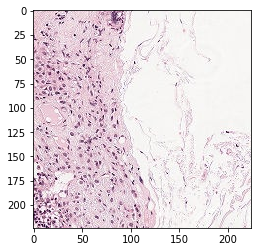

In [0]:
f = 240
plt.imshow(full_dataset_train[3][f])
print(full_dataset_Yi_train[3][f])

# CONFIGURE MODEL

In [0]:
'''
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers

model_inputs = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))

transfer_resnet = ResNet50(include_top=False, weights='imagenet')(model_inputs)
model = Flatten()(transfer_resnet)
model = Dense(8, activation='relu')(model)
model = Dropout(0.1)(model)
out = Flatten()(model)

vison_model = Model(model_inputs, out)

layer_1 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))
layer_2 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))
layer_3 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))
layer_4 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))
layer_5 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))

out_layer_1 = vison_model(layer_1)
out_layer_2 = vison_model(layer_2)
out_layer_3 = vison_model(layer_3)
out_layer_4 = vison_model(layer_4)
out_layer_5 = vison_model(layer_5)

model_concat = concatenate([out_layer_1,
                            out_layer_2,
                            out_layer_3,
                            out_layer_4,
                            out_layer_5])

dense = layers.Dense(64,activation='relu')(model_concat)
dense = layers.Dense(32,activation='relu')(dense)
output = layers.Dense(1, activation='sigmoid')(dense)

classification_model = Model ([layer_1,
                               layer_2,
                               layer_3,
                               layer_4,
                               layer_5], output)

classification_model.summary()
'''

"\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, concatenate\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras import layers\n\nmodel_inputs = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))\n\ntransfer_resnet = ResNet50(include_top=False, weights='imagenet')(model_inputs)\nmodel = Flatten()(transfer_resnet)\nmodel = Dense(8, activation='relu')(model)\nmodel = Dropout(0.1)(model)\nout = Flatten()(model)\n\nvison_model = Model(model_inputs, out)\n\nlayer_1 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))\nlayer_2 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))\nlayer_3 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))\nlayer_4 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))\nlayer_5 = Input(shape=(SAMPLE_SIZE, SAMPLE_SIZE, 3))\n\nout_layer_1 = vison_model(layer_1)\nout_layer_2 = vison_model(layer_2)\nout_layer_3 = vison_model(layer_3)\nout_layer_4 = vison_model(layer_4)\nout_layer_5 = vison_model(layer_5)\n\nmodel_concat = concatenate([out_layer_1

In [0]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model, Sequential

transfer_resnet = ResNet50(include_top=False, 
                           weights='imagenet', 
                           input_shape=(SAMPLE_SIZE,SAMPLE_SIZE,3))

model = Sequential()
model.add(transfer_resnet)
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

opt = RMSprop(learning_rate=0.001, momentum=.7)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3211296   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 26,799,553
Trainable params: 26,746,433
Non-trainable params: 53,120
_____________________________________

In [0]:
train_epochs  = 5
history = [[],[],[],[],[]]

for x in range(5):
  history[x] = model.fit(x=full_dataset_train[x],
                    y=full_dataset_Yi_train[x],
                    batch_size=32,
                    validation_data=(full_dataset_val[x],full_dataset_Yi_val[x]),
                    epochs=train_epochs
                    )

Train on 9008 samples, validate on 1126 samples
Epoch 1/5
9008/9008 [==============================] - 55s 6ms/sample - loss: 0.9008 - accuracy: 0.8224 - val_loss: 39.0439 - val_accuracy: 0.6306
Epoch 2/5
9008/9008 [==============================] - 49s 5ms/sample - loss: 0.3643 - accuracy: 0.8788 - val_loss: 17.6685 - val_accuracy: 0.6306
Epoch 3/5
9008/9008 [==============================] - 49s 5ms/sample - loss: 0.3341 - accuracy: 0.8937 - val_loss: 2.5389 - val_accuracy: 0.6306
Epoch 4/5
9008/9008 [==============================] - 49s 5ms/sample - loss: 0.2962 - accuracy: 0.8989 - val_loss: 1.1233 - val_accuracy: 0.6901
Epoch 5/5
9008/9008 [==============================] - 49s 5ms/sample - loss: 0.2796 - accuracy: 0.9056 - val_loss: 0.3713 - val_accuracy: 0.8428
Train on 5040 samples, validate on 630 samples
Epoch 1/5
5040/5040 [==============================] - 28s 5ms/sample - loss: 0.3063 - accuracy: 0.8849 - val_loss: 0.3853 - val_accuracy: 0.8349
Epoch 2/5
5040/5040 [======

# RESULTS

Plots for Level 0


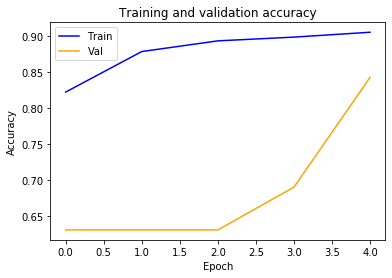

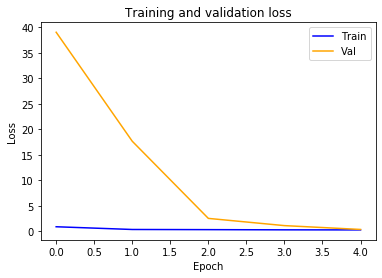

In [0]:
print("Plots for Level 0")
plot(history[0])

Plots for Level 1


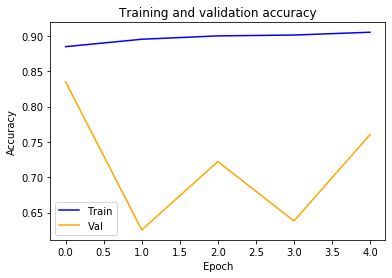

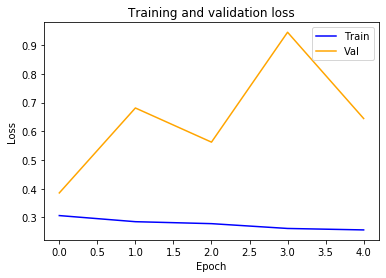

In [0]:
print("Plots for Level 1")
plot(history[1])

Plots for Level 2


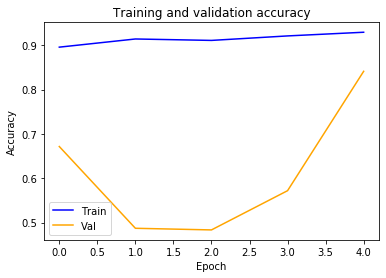

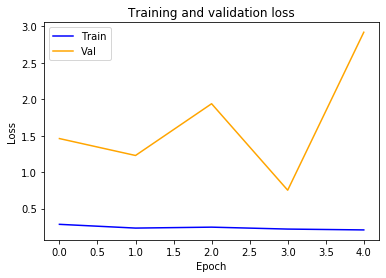

In [0]:
print("Plots for Level 2")
plot(history[2])

Plots for Level 3


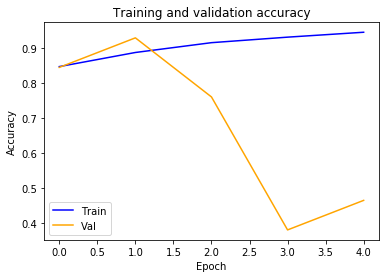

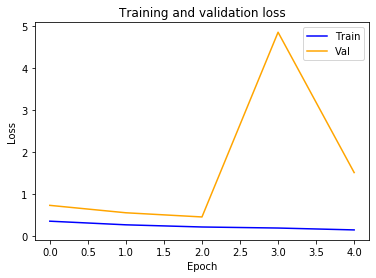

In [0]:
print("Plots for Level 3")
plot(history[3])

Plots for Level 4


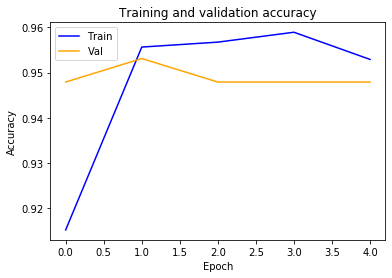

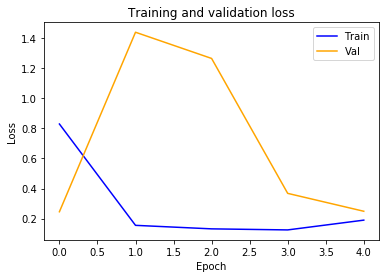

In [0]:
print("Plots for Level 4")
plot(history[4])

In [0]:
predictions = [[],[],[],[],[]]

for x in range(5):
  predictions[x] = model.evaluate(full_dataset_test[x],full_dataset_Yi_test[x])

193/193 [==============================] - 0s 2ms/sample - loss: 0.2542 - accuracy: 0.9430


In [0]:
for i, val in enumerate(predictions[4]):
  if val > 0.6:
    print(i)

1


Model prediction for cancer existing on this slide as a probability: 0.9430


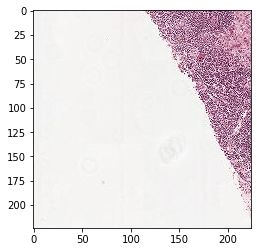

In [0]:
data_zoom_level = 4
slide_num       = 1

plt.imshow(full_dataset_test[data_zoom_level][slide_num])
print("Model prediction for cancer existing on this slide as a probability: %.4f" 
      %predictions[data_zoom_level][slide_num])


Model prediction for cancer existing on this slide as a probability: 2.1123


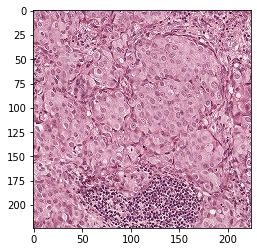

In [0]:
data_zoom_level = 3
slide_num       = 0

plt.imshow(full_dataset_test[data_zoom_level][slide_num])
print("Model prediction for cancer existing on this slide as a probability: %.4f" 
      %predictions[data_zoom_level][slide_num])


Model prediction for cancer existing on this slide as a probability: 1.5436


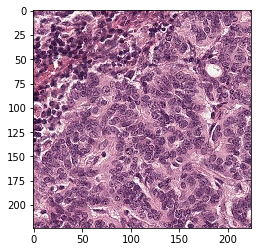

In [0]:
data_zoom_level = 2
slide_num       = 0

plt.imshow(full_dataset_test[data_zoom_level][slide_num])
print("Model prediction for cancer existing on this slide as a probability: %.4f" 
      %predictions[data_zoom_level][slide_num])

Model prediction for cancer existing on this slide as a probability: 1.2254


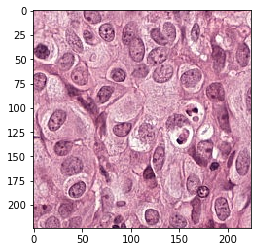

In [0]:
data_zoom_level = 1
slide_num       = 0

plt.imshow(full_dataset_test[data_zoom_level][slide_num])
print("Model prediction for cancer existing on this slide as a probability: %.4f" 
      %predictions[data_zoom_level][slide_num])

Model prediction for cancer existing on this slide as a probability: 1.0201


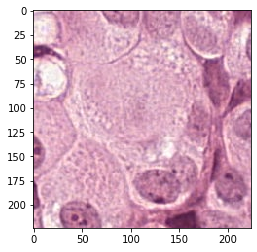

In [0]:
data_zoom_level = 0
slide_num       = 0
plt.imshow(full_dataset_test[data_zoom_level][slide_num])
print("Model prediction for cancer existing on this slide as a probability: %.4f" 
      %predictions[data_zoom_level][slide_num])